# Cluster Feature Class

In [6]:
import numpy as np
from scipy.spatial.distance import euclidean

class ClusteringFeature:
    def __init__(self, data_point):
        self.n = 1  # Number of data points
        self.linear_sum = np.array(data_point)  # Linear sum of data points
        self.squared_sum = np.sum(np.square(data_point))  # Squared sum for computing variance
        self.children = []
        self.data_points = [data_point]

    def update(self, data_point):
        self.n += 1
        self.linear_sum += data_point
        self.squared_sum += np.sum(np.square(data_point))
        self.data_points.append(data_point)

    def centroid(self):
        return self.linear_sum / self.n

    def radius(self):
        return np.sqrt(self.squared_sum / self.n - np.square(self.centroid()))

    def distance(self, data_point):
        return euclidean(self.centroid(), data_point)

# CF Node class

In [7]:
class CFNode:
    def __init__(self, threshold, is_leaf=True):
        self.threshold = threshold
        self.is_leaf = is_leaf
        self.children = []  # List of ClusteringFeatures or CFNodes
        self.parent = None

    def insert(self, data_point, adaptive_threshold):
        # If there are no children, we need to create the first child
        if not self.children:
            new_cf = ClusteringFeature(data_point)
            self.children.append(new_cf)
            return
        
        # Find closest child
        closest_child = self.find_closest_child(data_point)
        
        if closest_child is not None:
            if closest_child.distance(data_point) < adaptive_threshold:
                closest_child.update(data_point)
            else:
                new_cf = ClusteringFeature(data_point)
                self.children.append(new_cf)
                if len(self.children) > self.threshold:
                    self.split_node()
        else:
            closest_child.insert(data_point, adaptive_threshold)

    def find_closest_child(self, data_point):
         # If there are no children, we cannot find a closest child
        if not self.children:
            return None
        # Find the closest CF or CFNode to the data point
        closest_child = None
        min_distance = float('inf')
        for child in self.children:
            # If the child is a ClusteringFeature, compute distance directly
            if isinstance(child, ClusteringFeature):
                dist = child.distance(data_point)
            # If the child is a CFNode, perhaps use some aggregate distance measure
            elif isinstance(child, CFNode) and child.is_leaf:
                # This should not happen: a CFNode's children should be ClusteringFeatures if it's a leaf
                raise Exception("Non-leaf CFNode encountered in leaf node's children")
            else:
                # If the child is a non-leaf CFNode, you might choose the distance to the closest ClusteringFeature within it
                dist = child.find_closest_child(data_point).distance(data_point)
            
            if dist < min_distance:
                min_distance = dist
                closest_child = child
        return closest_child

    def split_node(self):
        # Logic to split the node when it exceeds the threshold
        # For simplicity, we'll split into two nodes
        new_node1 = CFNode(self.threshold, self.is_leaf)
        new_node2 = CFNode(self.threshold, self.is_leaf)
        for child in self.children:
            if len(new_node1.children) < len(self.children) // 2:
                new_node1.children.append(child)
            else:
                new_node2.children.append(child)
        self.children = [new_node1, new_node2]
    
    def get_clusters(self):
        if self.is_leaf:
            return self.children
        else:
            clusters = []
            for child in self.children:
                clusters.extend(child.get_clusters())
            return clusters

# Calculate Adaptive Threshold function

In [8]:
def calculate_adaptive_threshold(current_memory_usage, max_memory_limit):
    # For simplicity, let's say it's a linear function
    return max(1, max_memory_limit - current_memory_usage)  # Ensure we always have a threshold of at least 1

# BIRCH class

In [9]:
from queue import Queue
class BIRCH:
    def __init__(self, initial_threshold, max_memory_limit):
        self.root = CFNode(initial_threshold)
        self.max_memory_limit = max_memory_limit
        self.memory_usage = 0  # Initialize memory usage

    def fit(self, data):
        for data_point in data:
            # Simulate memory usage calculation (to be replaced with real memory monitoring)
            self.memory_usage += data_point.nbytes  # Update memory usage for each data point
            #adaptive_threshold = calculate_adaptive_threshold(self.memory_usage, self.max_memory_limit)
            adaptive_threshold = 0

            # Find the closest leaf node and insert the data point
            closest_leaf = self.find_closest_leaf(self.root, data_point)
            closest_leaf.insert(data_point, adaptive_threshold)

    def find_closest_leaf(self, node, data_point):
        # Breadth-first search to find the closest leaf node
        queue = Queue()
        queue.put(node)
        while not queue.empty():
            current_node = queue.get()
            if current_node.is_leaf:
                return current_node
            else:
                closest_child = current_node.find_closest_child(data_point)
                queue.put(closest_child)

In [10]:
from sklearn import datasets

iris = datasets.load_iris()
data = iris.data

birch_instance = BIRCH(initial_threshold=3, max_memory_limit=1000)  # Adjust max_memory_limit as needed
birch_instance.fit(data)
clusters = birch_instance.root.get_clusters()

Exception: Non-leaf CFNode encountered in leaf node's children

Cluster 0 has 1200 points.


C:\Users\dmaxw\AppData\Local\Temp\ipykernel_13292\3761572935.py:17: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(data_points[:, 0], data_points[:, 1], s=30, c=color, label=f'Cluster {cluster_index}')


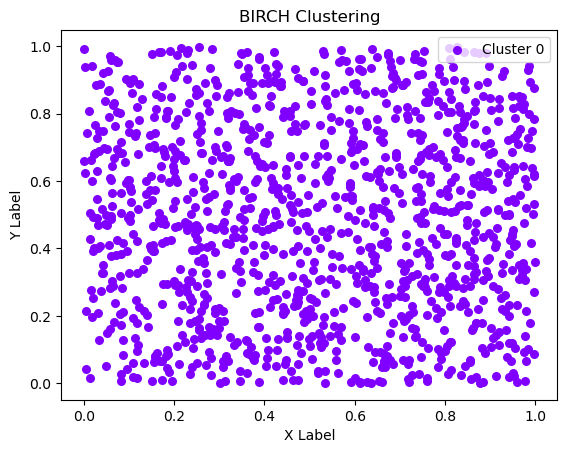

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(clusters))))

for cluster_index, cluster in enumerate(clusters):
    print(f"Cluster {cluster_index} has {len(cluster.data_points)} points.")
    # Assuming data_points is a list of numpy arrays or a 2D numpy array
    data_points = np.array(cluster.data_points)   # Get the data points for this cluster
    if len(data_points) == 0:
        continue

    color = next(colors)  # Get the next color in the color map

    # Now you can safely index data_points assuming it is 2D
    ax.scatter(data_points[:, 0], data_points[:, 1], s=30, c=color, label=f'Cluster {cluster_index}')

    # For 3D visualization (uncomment the following lines)
    # ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=30, c=color, label=f'Cluster {cluster.id}')
    # Draw the sphere boundary for the cluster (this can be tricky in 3D)

ax.set_title('BIRCH Clustering')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')

# For 3D visualization (uncomment the following line)
# ax.set_zlabel('Z Label')

plt.legend()
plt.show()